<a href="https://colab.research.google.com/github/parhambarazesh/PET575/blob/master/Flow_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Text(0.5, 1.0, 'Controller values')

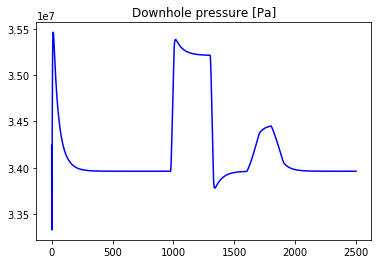

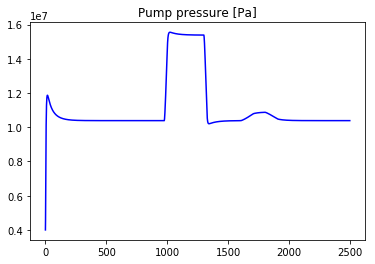

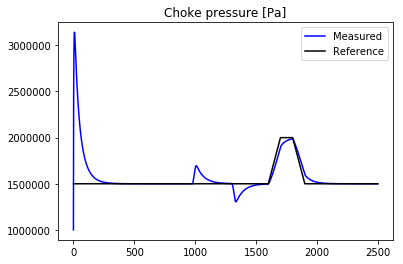

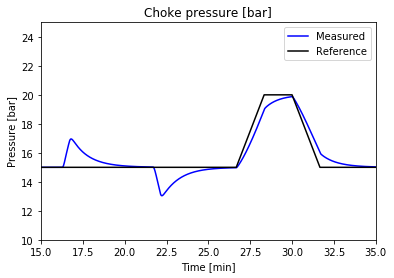

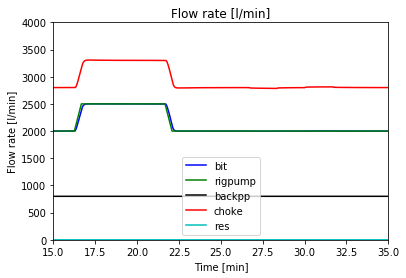

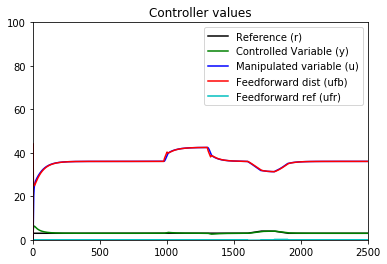

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# Constants
maxtime = 2500 # seconds
dt = 0.001 # euler step time
Ts = 1# loop time step
#Operator parameters
q_p = 2000/60000 # 2000 l/min
q_bpp = 800/60000 # 800 l/min
q_c = q_p + q_bpp # 2800 l/min
z_c = 0.1 # choke opening
# Wellbore parameters
h = 1951
beta_d =2e9
beta_a =1e9
V_d =17 # m3
V_a = 48 #m3
M = 4.3e8
Fd = 5e9
Fb = 1e9
Fa = 2e9
rho_d = 1580
rho_a = 1580
g = 9.81
k_c = 0.021
# Define range
p_min=0*10**7 # p_p_m
p_max=5.0*10**7 # p_bhp_m
z_min=0
z_max=0.20
# reservoir parameters
p_pore = 3.15e7
p_frac = 3.75e7
ProdIndex = (100/60000)/5e5 # 100 l/min at delta p of 5 bar
# 'permeability'
#Array initialization
p_p_ar = np.zeros(maxtime)
p_c_ar = np.zeros(maxtime)
p_b_ar = np.zeros(maxtime)
q_b_ar = np.zeros(maxtime)
q_c_ar = np.zeros(maxtime)
q_p_ar = np.zeros(maxtime)
q_bpp_ar = np.zeros(maxtime)
q_res_ar = np.zeros(maxtime)
r_ar = np.zeros(maxtime)
u_ar = np.zeros(maxtime)
y_ar = np.zeros(maxtime)
ufd_ar = np.zeros(maxtime)
# Initial values
p_p = 40e5
p_c = 10e5
q_b = 2000/60000
p_b = p_p + rho_d*g*h
#reference value
p_c_r = 15e5
#Initialize controller
e = 0
u = 0
ufd = 0
ufr = 0
ufb = 0
y = 0
r = 0
Kp = 6
Ki = 0.2

p_p_ar = np.zeros(maxtime)
p_c_ar = np.zeros(maxtime)
p_c_r_ar = np.zeros(maxtime)
p_b_ar = np.zeros(maxtime)
q_b_ar = np.zeros(maxtime)
q_p_ar = np.zeros(maxtime)
q_c_ar = np.zeros(maxtime)
q_bpp_ar = np.zeros(maxtime)
q_res_ar = np.zeros(maxtime)
u_ar = np.zeros(maxtime)
y_ar = np.zeros(maxtime)
r_ar = np.zeros(maxtime)
ufd_ar = np.zeros(maxtime)
ufr_ar = np.zeros(maxtime)
    
    
# main iteration loop
for time in range(0,maxtime):
    p_c_r_last = p_c_r
    # change mud pump rate
    if (time > 975) and (time <= 1000):
        q_p = q_p + 20/60000 # ramp up to 2500 l/min

    if (time > 1200) and (time <= 1300):
        q_p = 2500/60000 # fixed at 2500 l/min

    if (time > 1300) and (time <= 1325):
        # q_p = 1000/60000 # fixed at 2500 l/min
        q_p = q_p - 20/60000 # ramp up to 2500 l/min
        
    if (time > 1600) and (time <= 1700):
        p_c_r = p_c_r + 5e5/100
        
    if (time > 1800) and (time <= 1900):
        p_c_r = p_c_r - 5e5/100
        
    #Pore pressure
    q_res = ProdIndex*(p_pore - p_b)
    if q_res < 0:
        q_res = 0
        
        
    # Frac pressure
    q_loss = ProdIndex*(p_frac -p_b)
    
    if q_loss > 0:
        q_loss = 0
    
    #store parameters
    p_p_ar[time] = p_p
    p_c_ar[time] = p_c
    p_c_r_ar[time] = p_c_r
    p_b_ar[time] = p_b
    q_b_ar[time] = q_b
    q_p_ar[time] = q_p
    q_c_ar[time] = q_c
    q_bpp_ar[time] = q_bpp
    q_res_ar[time] = q_res
    u_ar[time] = u
    y_ar[time] = y
    r_ar[time] = r
    ufd_ar[time] = ufd
    ufr_ar[time] = ufr
    
    # Controller code
    # Feed forward from disturbance
    zfr = ((V_a/beta_a)*(p_c_r_last-p_c_r))/(k_c*np.sqrt(p_c/rho_a))
    zfd = (q_p + q_bpp)/(k_c*np.sqrt(p_c/rho_a))
    # scale to percentace
    r = ((p_c_r-p_min)/p_max)*100.0 # reference is p_c
    y = ((p_c-p_min)/p_max)*100.0 # controlled variable
    u = ((z_c-z_min)/z_max)*100.0 # manipulated variable
    # ufd_last = ufd
    ufd = ((zfd-z_min)/z_max)*100.0 # feed forward disturbance
    ufr = ((zfr-z_min)/z_max)*100.0 # feed forward disturbance
    #ufb = u
    # controller code
    last_e = e
    e=y-r
    # delta_u=Kp*(e-last_e)+((Kp*Ts)/Ti)*e; % using Kp and Ti
    delta_u=Kp*(e-last_e)+(Ki*Ts)*e # using Kp and Ki
    ufb=ufb+delta_u # feedback
    u = ufb#+ufd+ufr;
    # u = ufb+ufd_last; % +ufd+ufr; with time delay
    # u = ufb+ufd; % +ufd+ufr;
    # u = ufb+ufd+ufr; % +ufd+ufr;
    # limit u
    
    if u<=0:
        u=0

    if u>100:
        u=100

    #scale to physical values (only z are needed
    z_c_old = z_c
    z_c = z_min + z_max*(u/100.0)
    # Euler integration loop
    
    for eulerstep in np.arange(1,(1/dt)):
        p_pdot = (beta_d/V_d)*(q_p-q_b)
        q_bdot = 1/M*((p_p-p_c)-(Fd+Fb+Fa)*q_b*q_b+(rho_d-rho_a)*g*h)
        p_cdot = (beta_a/V_a)*(q_b+q_res+q_bpp+q_loss-q_c)
        p_p = p_p + p_pdot*dt
        q_b = q_b + q_bdot*dt
        p_c = p_c + p_cdot*dt
        q_c = z_c*k_c*np.sqrt(p_c/rho_a)
        p_b1 = p_p+rho_d*g*h-(Fd+Fb)*q_b*q_b # pump pressure
        p_b = p_c+rho_a*g*h+Fa*q_b*q_b # using choke pressure

plt.figure(1)
plt.plot(np.arange(0,maxtime),p_b_ar,'b')
plt.title('Downhole pressure [Pa]')

plt.figure(2)
plt.plot(np.arange(0,maxtime),p_p_ar,'b')
plt.title('Pump pressure [Pa]')

plt.figure(3)
plt.plot(np.arange(0,maxtime),p_c_ar,'b')
plt.plot(np.arange(0,maxtime),p_c_r_ar,'k')
plt.legend(['Measured','Reference'])
plt.title('Choke pressure [Pa]')

plt.figure(4)
plt.plot(np.arange(0,maxtime)/60,p_c_ar/1e5,'b')
plt.plot(np.arange(0,maxtime)/60,p_c_r_ar/1e5,'k')
plt.legend(['Measured','Reference'])
plt.xlabel('Time [min]')
plt.ylabel('Pressure [bar]')
plt.axis([15,35,10,25])
plt.title('Choke pressure [bar]')

plt.figure(5)
plt.plot(np.arange(0,maxtime)/60,q_b_ar*60000,'b')
plt.plot(np.arange(0,maxtime)/60,q_p_ar*60000,'g')
plt.plot(np.arange(0,maxtime)/60,q_bpp_ar*60000,'k')
plt.plot(np.arange(0,maxtime)/60,q_c_ar*60000,'r')
plt.plot(np.arange(0,maxtime)/60,q_res_ar*60000,'c')
plt.title('Flow rate [l/min]')
plt.xlabel('Time [min]')
plt.ylabel('Flow rate [l/min]')
plt.axis([15,35,0,4000])
plt.legend(['bit','rigpump','backpp','choke','res'])

plt.figure(6)
plt.plot(np.arange(0,maxtime),r_ar,'k')
plt.plot(np.arange(0,maxtime),y_ar,'g')
plt.plot(np.arange(0,maxtime),u_ar,'b')
plt.plot(np.arange(0,maxtime),ufd_ar,'r')
plt.plot(np.arange(0,maxtime),ufr_ar,'c')
plt.legend(['Reference (r)','Controlled Variable (y)','Manipulated variable (u)','Feedforward dist (ufb)','Feedforward ref (ufr)'])
plt.axis([1,maxtime,0,100])
plt.title('Controller values')